# CarND Behavioral Cloning Project

This project is about training a neural network to drive a car on a simulator using data recorded from a humman driver.

This notebook will be used to create the model to be used in driving the car on the simulator.

The inputs come in three images right, central and left cameras.

The first thing to do is to clean, then oganize the dataset, and save it to pickle file. for posterior use.

The file driving_log.csv contains steering angles and the left, right and center images associated to it.

In [1]:
import pickle
import csv
import numpy as np
import cv2
from sklearn.utils import shuffle
import numpy as np
from sklearn.model_selection import train_test_split
import os.path
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:


if not(os.path.exists('train.csv') and os.path.exists('validation.csv')):

    path_to_replace = "C:\\Users\\eduardo\\Documents\\SelfDrivingCar\\beta-simulator-windows\\beta_simulator_windows\\data"

    def ReplaceWrongPath(value):
        return value.replace(path_to_replace, "").replace("\\", "/").replace(" ", "")

    X_train = []
    y_train = []
    X_train_left = []
    y_train_left = []
    X_train_right = []
    y_train_right = []

    with open('./data/driving_log.csv', 'r') as csv_file_in:

        csv_reader = csv.DictReader(csv_file_in)

        for row in csv_reader:
            steering = float(row['steering'])

            #center image
            path = './data/' + ReplaceWrongPath(row['center'].strip())        
            X_train.append(path)
            y_train.append(steering)
            continue
            
            if steering == 0:
                continue
                
            if steering < 0:
                #left image
                path = './data/' + ReplaceWrongPath(row['left'].strip())
                steering_left = steering + 0.2

                X_train_left.append(path)
                y_train_left.append(steering_left)

                #right image
                path = './data/' + ReplaceWrongPath(row['right'].strip())
                steering_right = steering - 0.2
                steering_right = steering_right if steering_right > -1 else -1

                X_train_right.append(path)
                y_train_right.append(steering_right)
            else:
                #left image
                path = './data/' + ReplaceWrongPath(row['left'].strip())
                steering_left = steering + 0.2
                steering_left = steering_left if steering_left < 1 else 1

                X_train_left.append(path)
                y_train_left.append(steering_left)

                #right image
                path = './data/' + ReplaceWrongPath(row['right'].strip())
                steering_right = steering - 0.2

                X_train_right.append(path)
                y_train_right.append(steering_right)

    X_train, y_train = shuffle(X_train, y_train)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    [X_train.append(item) for item in X_train_left]
    [X_train.append(item) for item in X_train_right]
    [y_train.append(item) for item in y_train_left]
    [y_train.append(item) for item in y_train_right]
    
    X_train, y_train = shuffle(X_train, y_train)

    with open('train.csv', 'w') as csv_file_train:

        fieldnames = ['path','steering']
        writer = csv.DictWriter(csv_file_train, fieldnames=fieldnames)
        writer.writeheader()

        for i in range(len(X_train)):
            path, steering = X_train[i], y_train[i]
            writer.writerow({'path': path, 'steering': steering})

    with open('validation.csv', 'w') as csv_file_train:

        fieldnames = ['path','steering']
        writer = csv.DictWriter(csv_file_train, fieldnames=fieldnames)
        writer.writeheader()

        for i in range(len(X_validation)):
            path, steering = X_validation[i], y_validation[i]
            writer.writerow({'path': path, 'steering': steering})

    print("processing done")
else:
    print("files exist")

files exist


### Load data 

In [3]:
import sys

def turn_linear_to_logistic(steering, n_classes):
    interval = 2/n_classes
    classes = []
    lower_bound = -1
    
    for i in range(n_classes):
        upper_bound = lower_bound + interval if i < (n_classes-1) else 1
        classes.append(1 if steering > lower_bound and steering < upper_bound else 0)
        lower_bound += interval
        
    return np.array(classes)
    
    
break_classes = 21
X_train_left = None
y_train_left = None
X_train_right = None
y_train_right = None

X_train= []
y_train = []

with open('train.csv', 'r') as csv_file_train:
    
    csv_reader = csv.DictReader(csv_file_train)

    for row in csv_reader:
        X_train.append(row['path'])
        y_train.append(float(row['steering']))
        

X_validation = []
y_validation = []

with open('validation.csv', 'r') as csv_file_val:
    
    csv_reader = csv.DictReader(csv_file_val)

    for row in csv_reader:
        X_validation.append(row['path'])
        y_validation.append(float(row['steering']))
        
print('Loading done')
        

Loading done


### Explore data

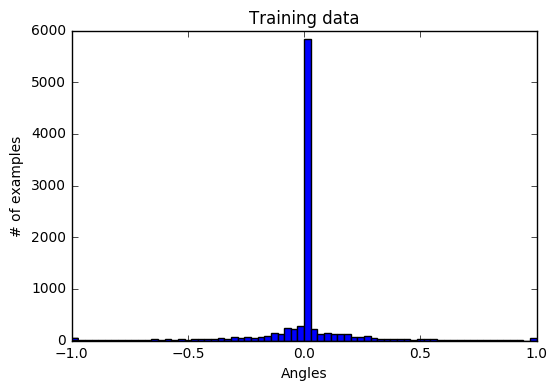

In [4]:
plt.hist(y_train, bins=70)
plt.title("Training data")
plt.xlabel("Angles")
plt.ylabel("# of examples")
plt.show()


### Normalize

In [5]:
def normalize(image_data):
    a = -0.5
    b = 0.5
    img_min = 0
    img_max = 255
    return a + ( ( (image_data - img_min)*(b - a) )/( img_max - img_min ) )

# Model

#### VGG with drop out, batch normalition

#### 20 EPOCHS Adam optimizer linear regression

#### Validation


In [6]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Lambda, Dense, Activation, Flatten, Input, Dropout, Convolution2D, MaxPooling2D, Cropping2D
from keras.layers.normalization import BatchNormalization

def get_model():
    input_tensor = Input(shape=(160, 320, 3))
    croped_input_img = Cropping2D(cropping=((60, 20), (0, 0)))(input_tensor)
    croped_input_img = Lambda(lambda x: (x / 255.0) - 0.5)(croped_input_img)
    base_model = VGG16(input_tensor=croped_input_img, weights='imagenet', include_top=False)

    for layer in base_model.layers:
        layer.trainable = False

    top_model = base_model.output
    top_model = Flatten()(top_model)

    top_model = Dense(1024)(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Activation('relu')(top_model)
    top_model = Dropout(0.5)(top_model)

    top_model = Dense(100)(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Activation('relu')(top_model)
    top_model = Dropout(0.5)(top_model)

    top_model = Dense(50)(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Activation('relu')(top_model)
    top_model = Dropout(0.5)(top_model)

    top_model = Dense(10)(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Activation('relu')(top_model)
    top_model = Dropout(0.5)(top_model)

    predictions = Dense(1)(top_model)

    model = Model(input=input_tensor, output=predictions)
    return model

Using TensorFlow backend.


from keras.layers import merge, ZeroPadding2D, Cropping2D, Convolution2D, MaxPooling2D, Input, Lambda, Flatten, Dense, Activation, Dropout
from keras.models import Model

def AddConvLayer(features, kernel, input_layer):
    complex_layer = ZeroPadding2D((1,1))(input_layer)
    complex_layer = Convolution2D(features, kernel[0], kernel[1], activation='relu')(complex_layer)
    complex_layer = Dropout(0.5)(complex_layer)
    complex_layer = ZeroPadding2D((1,1))(complex_layer)
    complex_layer = Convolution2D(features, kernel[0], kernel[1], activation='relu')(complex_layer)
    complex_layer = Dropout(0.5)(complex_layer)
    complex_layer = MaxPooling2D((2,2), strides=(2,2))(complex_layer)
    return complex_layer

def AddDenseLayer(neurons, depth, layer):
    for i in range(depth):
        layer = Dense(neurons, activation='relu')(layer)
        layer = Dropout(0.5)(layer)
    return layer


input_img = Input(shape=(160, 320, 3))
croped_input_img = Cropping2D(cropping=((60, 20), (0, 0)))(input_img)
croped_input_img = Lambda(lambda x: (x / 255.0) - 0.5)(croped_input_img)

#tower_1 = AddConvLayer(6, (3, 2), croped_input_img)
#tower_1 = AddConvLayer(6, (3, 2), tower_1)
#tower_1 = AddConvLayer(6, (3, 2), tower_1)
#tower_1 = AddConvLayer(16, (3, 2), tower_1)
#tower_1 = AddConvLayer(16, (3, 2), tower_1)
#tower_1 = AddConvLayer(16, (3, 2), tower_1)
#tower_1 = Flatten()(tower_1)
#tower_1 = AddDenseLayer(1024, 2, tower_1)

tower_2_1 = AddConvLayer(32, (5, 5), croped_input_img)

tower_2_1_1 = AddConvLayer(64, (5, 5), tower_2_1)

tower_2_1_1_1 = AddConvLayer(128, (5, 5), tower_2_1_1)
tower_2_1_1_2 = AddConvLayer(256, (3, 3), tower_2_1_1_1)
tower_2_1_1_3 = AddConvLayer(512, (3, 3), tower_2_1_1_2)
tower_2_1_1_4 = Flatten()(tower_2_1_1_3)

tower_2_1_2 = AddConvLayer(128, (5, 5), tower_2_1_1)
tower_2_1_3 = AddConvLayer(256, (3, 3), tower_2_1_2)
tower_2_1_4 = AddConvLayer(512, (3, 3), tower_2_1_3)
tower_2_1_5 = Flatten()(tower_2_1_4)

tower_2_2 = AddConvLayer(64, (5, 5), tower_2_1)
tower_2_3 = AddConvLayer(128, (5, 5), tower_2_2)
tower_2_4 = AddConvLayer(256, (3, 3), tower_2_3)
tower_2_5 = AddConvLayer(512, (3, 3), tower_2_4)
tower_2_6 = Flatten()(tower_2_5)

tower_2_6 = merge([tower_2_6, tower_2_1_5, tower_2_1_1_4], mode='concat', concat_axis=1)

output = AddDenseLayer(1024, 1, tower_2_6)
output = AddDenseLayer(84, 1, output)
output = AddDenseLayer(50, 1, output)

#tower_3 = AddConvLayer(6, (5, 2), croped_input_img)
#tower_3 = AddConvLayer(6, (5, 2), tower_3)
#tower_3 = AddConvLayer(16, (5, 2), tower_3)
#tower_3 = AddConvLayer(16, (5, 2), tower_3)
#tower_3 = Flatten()(tower_3)
#tower_3 = AddDenseLayer(1024, 2, tower_3)

#output = merge([tower_1, tower_2, tower_3], mode='concat', concat_axis=1)

predictions = Dense(56, activation='relu')(output)
predictions = Dropout(0.5)(predictions)
predictions = Dense(1, activation='tanh')(predictions)

model = Model(input=input_img, output=predictions)

In [7]:
def process_line(row):
    b,g,r = cv2.split(cv2.imread(row['path']))
    img = np.array(cv2.merge([r,g,b]))
        
    #steering = float(row['steering'])            
    steering = row['steering']
    return [img, steering]

def generate_arrays_from_file(path, batch_size = 20, flip=True):
    while 1:
        global X_train
        global y_train
        X_train, y_train = shuffle(X_train, y_train)
        Xs = []
        ys = []        
        for i in range(len(X_train)):
            if (len(Xs) == batch_size):
                yield (np.array(Xs), np.array(ys))
                Xs = []
                ys = []
                
            x, y = process_line({'path':X_train[i], 'steering':y_train[i]})
            Xs.append(x)
            ys.append(y)
            
            if flip:
                if (len(Xs) == batch_size):
                    yield (np.array(Xs), np.array(ys))
                    Xs = []
                    ys = []
                    
                x_flipped = np.fliplr(x)
                y_filpped = -y

                Xs.append(x_flipped)
                ys.append(y_filpped)

        yield (np.array(Xs), np.array(ys))
            

In [8]:
train_rows = len(X_train)
validation_rows = len(X_validation)
    
print('train records: ', train_rows)
print('validation records: ', validation_rows)

train records:  9215
validation records:  2304


In [9]:
for i, Layer in enumerate(model.layers):
    if i > 2 and i < 8:
        print(i, Layer.name, Layer.trainable)
    else:
        print(i, Layer.name, Layer.trainable)

0 input_1 False
1 cropping2d_1 False
2 lambda_1 False
3 block1_conv1 False
4 block1_conv2 False
5 block1_pool False
6 block2_conv1 False
7 block2_conv2 False
8 block2_pool False
9 block3_conv1 False
10 block3_conv2 False
11 block3_conv3 False
12 block3_pool False
13 block4_conv1 False
14 block4_conv2 False
15 block4_conv3 False
16 block4_pool False
17 block5_conv1 False
18 block5_conv2 False
19 block5_conv3 False
20 block5_pool False
21 flatten_1 True
22 dense_1 True
23 batchnormalization_1 True
24 activation_1 True
25 dropout_1 True
26 dense_2 True
27 batchnormalization_2 True
28 activation_2 True
29 dropout_2 True
30 dense_3 True
31 batchnormalization_3 True
32 activation_3 True
33 dropout_3 True
34 dense_4 True
35 batchnormalization_4 True
36 activation_4 True
37 dropout_4 True
38 dense_5 True


In [10]:
from keras.optimizers import RMSprop, Adam

model = get_model()
checkpoint = ModelCheckpoint("model.h5",
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only=True,
                                 mode='auto')

optimizer = RMSprop(lr=0.001)
model.compile(loss='mean_absolute_error', optimizer=optimizer)
history = model.fit_generator(generate_arrays_from_file('train.csv',batch_size=10), samples_per_epoch=train_rows*2, nb_epoch=2, validation_data=generate_arrays_from_file('validation.csv', batch_size=10, flip=False),nb_val_samples=validation_rows, callback=[checkpoint])

Epoch 1/2
18430/18430 [==============================] - 522s - loss: 0.1518 - val_loss: 0.0907
Epoch 2/2
18430/18430 [==============================] - 518s - loss: 0.0868 - val_loss: 0.0856


In [11]:
loss = 0
for i in range(len(X_validation)):
    val = X_validation[i]
    y = y_validation[i]
    imgs = []
    imgs.append(process_line({'path':val, 'steering':y})[0])
    pred = model.predict(np.array(imgs))
    loss += abs(y - pred[0][0])
    print('Truth: ', y, 'Pred: ', pred[0][0], 'Error: ', (y - pred[0][0]), 'Loss: ', loss/(i+1))

Truth:  -0.0754717 Pred:  -0.000794325 Error:  -0.0746773752671 Loss:  0.0746773752671
Truth:  0.3113208 Pred:  0.0343605 Error:  0.276960320437 Loss:  0.175818847852
Truth:  0.0 Pred:  -0.000794325 Error:  0.000794324732851 Loss:  0.117477340146
Truth:  0.0 Pred:  -0.000794325 Error:  0.000794324732851 Loss:  0.0883065862923
Truth:  -0.08490566 Pred:  -0.00748997 Error:  -0.0774156881835 Loss:  0.0861284066706
Truth:  0.0 Pred:  -0.000794325 Error:  0.000794324732851 Loss:  0.0719060596809
Truth:  0.5849057 Pred:  0.143245 Error:  0.441660986455 Loss:  0.124728192077
Truth:  0.0 Pred:  -0.000794325 Error:  0.000794324732851 Loss:  0.109236458659
Truth:  0.0 Pred:  -0.000794325 Error:  0.000794324732851 Loss:  0.0971873326674
Truth:  0.06603774 Pred:  -0.000794325 Error:  0.0668320647329 Loss:  0.0941518058739
Truth:  0.0 Pred:  -0.0285794 Error:  0.0285794436932 Loss:  0.0881906820393
Truth:  0.0 Pred:  -0.000794325 Error:  0.000794324732851 Loss:  0.0809076522638
Truth:  0.0 Pred:  -

In [12]:
for layer in model.layers:
    layer.trainable = True
    
model.save('model.h5')
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [13]:
#from keras.models import load_model, model_from_json

#json_file = open('model.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#loaded_model = model_from_json(loaded_model_json)
# load weights into new model
#model.load_weights("model.h5")

In [14]:
#for layer in model.layers:
#    layer.trainable = True

In [15]:
#json_file = open('model.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#loaded_model = model_from_json(loaded_model_json)
# load weights into new model
#model.load_weights("model1.h5")